In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import shutil 
from ultralytics import YOLO


In [192]:
train_df = pd.read_csv('Fetal Head Circumference Training Set.csv')

In [193]:
print(train_df.shape,"\n")
print(train_df.head(10),"\n")
print(train_df.info(),"\n")


(999, 3) 

     filename  pixel size(mm)  head circumference (mm)
0  000_HC.png        0.069136                    44.30
1  001_HC.png        0.089659                    56.81
2  002_HC.png        0.062033                    68.75
3  003_HC.png        0.091291                    69.00
4  004_HC.png        0.061240                    59.81
5  005_HC.png        0.115814                    69.80
6  006_HC.png        0.065606                    67.84
7  007_HC.png        0.109362                    62.80
8  008_HC.png        0.077655                    62.10
9  009_HC.png        0.121525                    62.31 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 999 non-null    object 
 1   pixel size(mm)           999 non-null    float64
 2   head circumference (mm)  999 non-null    float64
dtypes: 

In [2]:
def show_img(img, axis="off"):
    if type(img) == str:
        img = cv2.imread(img)
        plt.imshow(img)
        plt.axis(axis)
        plt.show()
    else:
        plt.imshow(img)
        plt.axis(axis)
        plt.show()

SPITING DATA

In [5]:
dir ="training_set"
os.makedirs("annotated_training_set", exist_ok=True)
os.makedirs("_training_set", exist_ok=True)
for filename in os.listdir(dir):
    if filename.endswith(".png"):
        if "Annotation" in filename:
            shutil.copy(os.path.join(dir, filename), os.path.join("annotated_training_set", filename))
        else:
            shutil.copy(os.path.join(dir, filename), os.path.join("_training_set", filename))

In [109]:
SOURCE_IMG_DIR ="/Users/hungcucu/Documents/usth/MLmedicine/FetalHeadCircumference/_training_set"
SOURCE_LBL_DIR = "/Users/hungcucu/Documents/usth/MLmedicine/FetalHeadCircumference/annotated_training_set"
IMG_DIR = "/Users/hungcucu/Documents/usth/MLmedicine/FetalHeadCircumference/yolodataset/images"
LBL_DIR = "/Users/hungcucu/Documents/usth/MLmedicine/FetalHeadCircumference/yolodataset/labels"
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(LBL_DIR, exist_ok=True)
os.makedirs(IMG_DIR+"/train", exist_ok=True)
os.makedirs(IMG_DIR+"/val", exist_ok=True)
os.makedirs(LBL_DIR+"/train", exist_ok=True)
os.makedirs(LBL_DIR+"/val", exist_ok=True)


In [110]:
files = [f for f in sorted(os.listdir(SOURCE_IMG_DIR))]
split_idx = int(len(files) * 0.8)
train_files = files[:split_idx]
val_files = files[split_idx:]
for file in train_files:
    shutil.copy(os.path.join(SOURCE_IMG_DIR, file), os.path.join(IMG_DIR+"/train", file))
for file in val_files:
    shutil.copy(os.path.join(SOURCE_IMG_DIR, file), os.path.join(IMG_DIR+"/val", file))

In [111]:
files = [f for f in sorted(os.listdir(SOURCE_LBL_DIR))]
split_idx = int(len(files) * 0.8)
train_files = files[:split_idx]
val_files = files[split_idx:]
for file in train_files:
    shutil.copy(os.path.join(SOURCE_LBL_DIR, file), os.path.join(LBL_DIR+"/train", file))
for file in val_files:
    shutil.copy(os.path.join(SOURCE_LBL_DIR, file), os.path.join(LBL_DIR+"/val", file))

In [103]:
def show_img(img, axis="off"):
    if type(img) == str:
        img = cv2.imread(img)
        plt.imshow(img)
        plt.axis(axis)
        plt.show()
    else:
        plt.imshow(img)
        plt.axis(axis)
        plt.show()

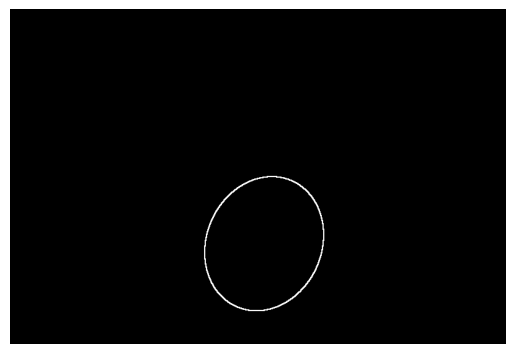

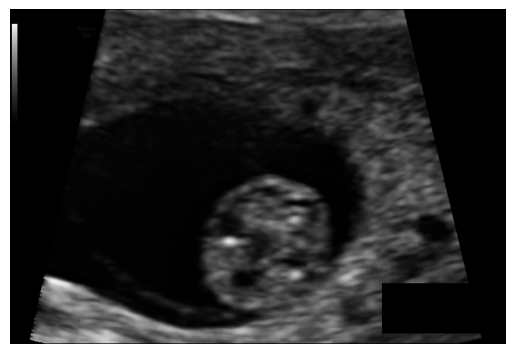

In [104]:
show_img(os.path.join("annotated_training_set", sorted(os.listdir("annotated_training_set"))[0]))   
show_img(os.path.join("_training_set",sorted(os.listdir("_training_set"))[0]))

In [112]:
def convert_to_yolo(ann_path,output_path:str,class_id:int=0):
    ###fill the contour
    ann = cv2.imread(ann_path,cv2.IMREAD_GRAYSCALE)
    img_h, img_w = ann.shape  
    contours, _ = cv2.findContours(ann, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled = np.zeros_like(ann)
    cv2.drawContours(filled,contours, -1, 255, thickness= -1)
    ###convert to yolo(polygon filled contour)
    contours, _ = cv2.findContours(filled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    poly = contours[0].reshape(-1, 2)  
    poly_norm = poly.astype(np.float32)
    poly_norm[:, 0] /= img_w
    poly_norm[:, 1] /= img_h
    flat = poly_norm.reshape(-1)
    line = str(class_id) + " " + " ".join([f"{v}" for v in flat]) + "\n"
    with open(output_path, "w") as f:
        f.write(line)

In [116]:
for file in os.listdir(LBL_DIR+"/train"):
    filepath = os.path.join(LBL_DIR+"/train",file)
    outputtxt = os.path.join(LBL_DIR+"/train",file.replace("_Annotation.png",".txt"))
    convert_to_yolo(filepath,outputtxt,0)
    os.remove(filepath)
for file in os.listdir(LBL_DIR+"/val"):
    filepath = os.path.join(LBL_DIR+"/val",file)
    outputtxt = os.path.join(LBL_DIR+"/val",file.replace("_Annotation.png",".txt"))
    convert_to_yolo(filepath,outputtxt,0)
    os.remove(filepath)

In [117]:
yaml_text="""path: /Users/hungcucu/Documents/usth/MLmedicine/FetalHeadCircumference/yolodataset
train: images/train
val: images/val

nc: 1
names: 
    0: head
"""
with open("/Users/hungcucu/Documents/usth/MLmedicine/FetalHeadCircumference/yolodataset/data.yaml", "w") as f:
    f.write(yaml_text)

print(open("/Users/hungcucu/Documents/usth/MLmedicine/FetalHeadCircumference/yolodataset/data.yaml", "r").read())

path: /Users/hungcucu/Documents/usth/MLmedicine/FetalHeadCircumference/yolodataset
train: images/train
val: images/val

nc: 1
names: 
    0: head



In [ ]:
!yolo task=segment model=yolo11s-seg.pt mode=train data=/Users/hungcucu/Documents/usth/MLmedicine/FetalHeadCircumference/yolodataset/data.yaml epochs=100 imgsz=640 batch=16 name=fetalheadcircumference-yolo26s-seg patience=30

TRAIN RESULTS USING KAGGLE NOTEBOOK

Downloading https://github.com/ultralytics/assets/releases/download/v8.4.0/yolo11s-seg.pt to 'yolo11s-seg.pt': 100% ━━━━━━━━━━━━ 19.7MB 118.1MB/s 0.2s1s<0.1s
Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolodataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=fetalheadcircumference-yolo26s-seg, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=30, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=None, rect=False, resume=False, retina_masks=False, rle=1.0, save=True, save_conf=False, save_crop=False, save_dir=/kaggle/working/runs/segment/fetalheadcircumference-yolo26s-seg, save_frames=False, save_json=False, save_period=-1, save_txt=False, scale=0.5, seed=0, shear=0.0, show=False, show_boxes=True, show_conf=True, show_labels=True, simplify=True, single_cls=False, source=None, split=val, stream_buffer=False, task=segment, time=None, tracker=botsort.yaml, translate=0.1, val=True, verbose=True, vid_stride=1, visualize=False, warmup_bias_lr=0.1, warmup_epochs=3.0, warmup_momentum=0.8, weight_decay=0.0005, workers=8, workspace=None
Downloading https://ultralytics.com/assets/Arial.ttf to '/root/.config/Ultralytics/Arial.ttf': 100% ━━━━━━━━━━━━ 755.1KB 16.8MB/s 0.0s
Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  8                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1    990976  ultralytics.nn.modules.block.C2PSA           [512, 512, 1]                 
 11                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 12             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 13                  -1  1    443776  ultralytics.nn.modules.block.C3k2            [768, 256, 1, False]          
 14                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 15             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 16                  -1  1    127680  ultralytics.nn.modules.block.C3k2            [512, 128, 1, False]          
 17                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 18            [-1, 13]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 19                  -1  1    345472  ultralytics.nn.modules.block.C3k2            [384, 256, 1, False]          
 20                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
 21            [-1, 10]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 22                  -1  1   1511424  ultralytics.nn.modules.block.C3k2            [768, 512, 1, True]           
 23        [16, 19, 22]  1   1474291  ultralytics.nn.modules.head.Segment          [1, 32, 128, 16, None, [128, 256, 512]]
YOLO11s-seg summary: 204 layers, 10,082,675 parameters, 10,082,659 gradients, 33.1 GFLOPs

Transferred 555/561 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
Downloading https://github.com/ultralytics/assets/releases/download/v8.4.0/yolo26n.pt to 'yolo26n.pt': 100% ━━━━━━━━━━━━ 5.3MB 69.1MB/s 0.1s
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2256.4±1010.6 MB/s, size: 134.9 KB)
train: Scanning /kaggle/working/yolodataset/labels/train... 799 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 799/799 479.6it/s 1.7s0.0s
train: New cache created: /kaggle/working/yolodataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 932.8±358.8 MB/s, size: 122.7 KB)
val: Scanning /kaggle/working/yolodataset/labels/val... 200 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 200/200 453.8it/s 0.4s0.1s
val: New cache created: /kaggle/working/yolodataset/labels/val.cache
Plotting labels to /kaggle/working/runs/segment/fetalheadcircumference-yolo26s-seg/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: MuSGD(lr=0.002, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /kaggle/working/runs/segment/fetalheadcircumference-yolo26s-seg
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
      1/100      4.71G     0.9246       2.47      2.565      1.294          0         44        640: 100% ━━━━━━━━━━━━ 50/50 1.2it/s 40.5s0.6ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 1.1s/it 7.7s0.4s2
                   all        200        200      0.995      0.999      0.995      0.863       0.99      0.994      0.992      0.861

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
      2/100      5.26G     0.5562      1.087       0.55      1.008          0         42        640: 100% ━━━━━━━━━━━━ 50/50 2.4it/s 21.1s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.3it/s 2.1s0.4s
                   all        200        200          1          1      0.995      0.903      0.995      0.995      0.994      0.899

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
      3/100      5.31G     0.5142     0.9777     0.3794     0.9642          0         34        640: 100% ━━━━━━━━━━━━ 50/50 2.5it/s 19.8s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.5it/s 2.0s0.4s
                   all        200        200          1          1      0.995      0.926      0.995      0.995      0.994      0.928

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
      4/100      5.35G     0.5267     0.8402     0.3761     0.9634          0         36        640: 100% ━━━━━━━━━━━━ 50/50 2.5it/s 19.7s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.5it/s 2.0s0.4s
                   all        200        200          1          1      0.995      0.932      0.995      0.995      0.991      0.921

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
      5/100      5.39G     0.5194     0.8534     0.3633      0.964          0         35        640: 100% ━━━━━━━━━━━━ 50/50 2.6it/s 19.6s0.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.5it/s 2.0s0.4s
                   all        200        200          1          1      0.995      0.938      0.995      0.995      0.993      0.927

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
      6/100      5.44G     0.5046     0.7925     0.3465     0.9542          0         38        640: 100% ━━━━━━━━━━━━ 50/50 2.5it/s 19.7s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.6it/s 2.0s0.3s
                   all        200        200      0.995          1      0.995      0.942       0.99      0.995      0.993      0.925

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
      7/100      5.48G      0.499     0.8189     0.3266     0.9546          0         49        640: 100% ━━━━━━━━━━━━ 50/50 2.6it/s 19.4s0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.4it/s 2.1s0.4s
                   all        200        200      0.999          1      0.995      0.933      0.994      0.995      0.995      0.934

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
      8/100      5.52G     0.5064     0.7755     0.3117     0.9649          0         38        640: 100% ━━━━━━━━━━━━ 50/50 2.5it/s 19.8s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.6it/s 1.9s0.3s
                   all        200        200          1          1      0.995      0.948      0.995      0.995      0.993       0.95

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
      9/100      5.57G     0.4851      0.807     0.3056     0.9483          0         41        640: 100% ━━━━━━━━━━━━ 50/50 2.6it/s 19.6s0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.6it/s 2.0s0.4s
                   all        200        200      0.999          1      0.995      0.939      0.994      0.995      0.993      0.938

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
     10/100      5.61G     0.4767     0.7204     0.2987     0.9424          0         44        640: 100% ━━━━━━━━━━━━ 50/50 2.5it/s 19.8s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.6it/s 2.0s0.3s
                   all        200        200          1          1      0.995      0.944      0.995      0.995      0.992      0.936

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
     11/100      5.65G     0.4811     0.7496     0.3035     0.9439          0         48        640: 100% ━━━━━━━━━━━━ 50/50 2.5it/s 19.6s0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.6it/s 1.9s0.3s
      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
      9/100      5.57G     0.4851      0.807     0.3056     0.9483          0         41        640: 100% ━━━━━━━━━━━━ 50/50 2.6it/s 19.6s0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.6it/s 2.0s0.4s
                   all        200        200      0.999          1      0.995      0.939      0.994      0.995      0.993      0.938

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
     10/100      5.61G     0.4767     0.7204     0.2987     0.9424          0         44        640: 100% ━━━━━━━━━━━━ 50/50 2.5it/s 19.8s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.6it/s 2.0s0.3s
                   all        200        200          1          1      0.995      0.944      0.995      0.995      0.992      0.936

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
     11/100      5.65G     0.4811     0.7496     0.3035     0.9439          0         48        640: 100% ━━━━━━━━━━━━ 50/50 2.5it/s 19.6s0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.6it/s 1.9s0.3s
      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
      9/100      5.57G     0.4851      0.807     0.3056     0.9483          0         41        640: 100% ━━━━━━━━━━━━ 50/50 2.6it/s 19.6s0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.6it/s 2.0s0.4s
                   all        200        200      0.999          1      0.995      0.939      0.994      0.995      0.993      0.938

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
     10/100      5.61G     0.4767     0.7204     0.2987     0.9424          0         44        640: 100% ━━━━━━━━━━━━ 50/50 2.5it/s 19.8s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.6it/s 2.0s0.3s
                   all        200        200          1          1      0.995      0.944      0.995      0.995      0.992      0.936

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
     11/100      5.65G     0.4811     0.7496     0.3035     0.9439          0         48        640: 100% ━━━━━━━━━━━━ 50/50 2.5it/s 19.6s0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.6it/s 1.9s0.3s
      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
      9/100      5.57G     0.4851      0.807     0.3056     0.9483          0         41        640: 100% ━━━━━━━━━━━━ 50/50 2.6it/s 19.6s0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.6it/s 2.0s0.4s
                   all        200        200      0.999          1      0.995      0.939      0.994      0.995      0.993      0.938

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
     10/100      5.61G     0.4767     0.7204     0.2987     0.9424          0         44        640: 100% ━━━━━━━━━━━━ 50/50 2.5it/s 19.8s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.6it/s 2.0s0.3s
                   all        200        200          1          1      0.995      0.944      0.995      0.995      0.992      0.936

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
     11/100      5.65G     0.4811     0.7496     0.3035     0.9439          0         48        640: 100% ━━━━━━━━━━━━ 50/50 2.5it/s 19.6s0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.6it/s 1.9s0.3s
      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
      9/100      5.57G     0.4851      0.807     0.3056     0.9483          0         41        640: 100% ━━━━━━━━━━━━ 50/50 2.6it/s 19.6s0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.6it/s 2.0s0.4s
                   all        200        200      0.999          1      0.995      0.939      0.994      0.995      0.993      0.938

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
     10/100      5.61G     0.4767     0.7204     0.2987     0.9424          0         44        640: 100% ━━━━━━━━━━━━ 50/50 2.5it/s 19.8s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.6it/s 2.0s0.3s
                   all        200        200          1          1      0.995      0.944      0.995      0.995      0.992      0.936

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
     11/100      5.65G     0.4811     0.7496     0.3035     0.9439          0         48        640: 100% ━━━━━━━━━━━━ 50/50 2.5it/s 19.6s0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.6it/s 1.9s0.3s
      

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
     68/100       5.5G      0.357     0.5036     0.1957     0.8961          0         38        640: 100% ━━━━━━━━━━━━ 50/50 2.5it/s 20.2s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.5it/s 2.0s0.4s
                   all        200        200          1          1      0.995      0.953      0.995      0.995      0.995      0.952

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
     69/100      5.55G     0.3443     0.4684     0.1909      0.884          0         40        640: 100% ━━━━━━━━━━━━ 50/50 2.5it/s 20.1s0.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.6it/s 2.0s0.4s
                   all        200        200          1          1      0.995      0.955      0.995      0.995      0.995       0.95

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
     70/100      5.59G     0.3317      0.454     0.1859     0.8845          0         49        640: 100% ━━━━━━━━━━━━ 50/50 2.5it/s 20.3s0.4ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.6it/s 2.0s0.4s
                   all        200        200          1          1      0.995      0.956      0.995      0.995      0.995      0.952
EarlyStopping: Training stopped early as no improvement observed in last 30 epochs. Best results observed at epoch 40, best model saved as best.pt.
To update EarlyStopping(patience=30) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

70 epochs completed in 0.444 hours.
Optimizer stripped from /kaggle/working/runs/segment/fetalheadcircumference-yolo26s-seg/weights/last.pt, 20.5MB
Optimizer stripped from /kaggle/working/runs/segment/fetalheadcircumference-yolo26s-seg/weights/best.pt, 20.5MB

Validating /kaggle/working/runs/segment/fetalheadcircumference-yolo26s-seg/weights/best.pt...
Ultralytics 8.4.7 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s-seg summary (fused): 114 layers, 10,067,203 parameters, 0 gradients, 32.8 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 2.4it/s 2.9s0.4s
                   all        200        200          1          1      0.995      0.956      0.995      0.995      0.994       0.96
Speed: 0.1ms preprocess, 4.1ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to /kaggle/working/runs/segment/fetalheadcircumference-yolo26s-seg
💡 Learn more at https://docs.ultralytics.com/modes/train

SEGMENT THE TEST IMAGES

In [ ]:
model = YOLO("/Users/hungcucu/Documents/usth/MLmedicine/FetalHeadCircumference/kaggle/working/runs/segment/fetalheadcircumference-yolo26s-seg/weights/best.pt")
os.makedirs("/Users/hungcucu/Documents/usth/MLmedicine/FetalHeadCircumference/predicted_test_set", exist_ok=True)
results = model.predict(
        source="/Users/hungcucu/Documents/usth/MLmedicine/FetalHeadCircumference/test_set",
        conf=0.25,
        iou=0.7,
        stream=True,
        verbose=False
    )
for r in results:
    filename = os.path.basename(r.path).replace(".png", "_seg.png")
    outputfile = os.path.join("/Users/hungcucu/Documents/usth/MLmedicine/FetalHeadCircumference/predicted_test_set", filename)
    annotated = r.plot()
    cv2.imwrite(outputfile, annotated)


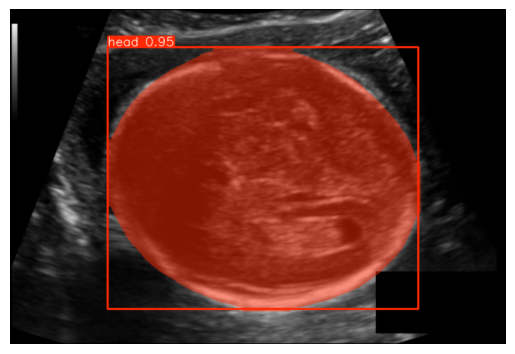

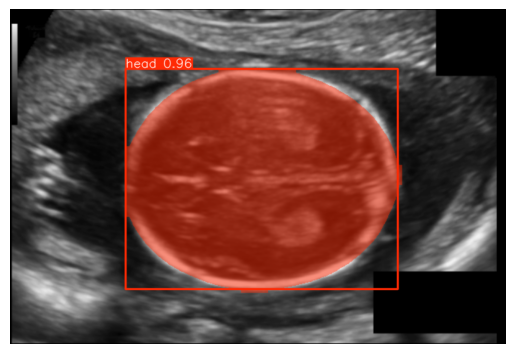

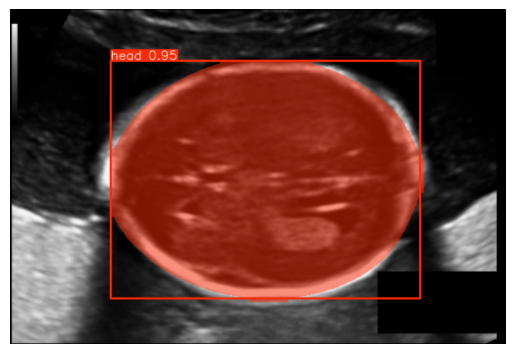

In [173]:
for f in os.listdir("/Users/hungcucu/Documents/usth/MLmedicine/FetalHeadCircumference/predicted_test_set")[:3]:
    show_img(os.path.join("/Users/hungcucu/Documents/usth/MLmedicine/FetalHeadCircumference/predicted_test_set", f))

EVALUATION OF HC ON TRAINING CSV FILE 

In [195]:
import math
def calculate_ellipse_perimeter(path,pixel_size):
    ann =cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    contours, _ = cv2.findContours(ann, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    ellipse = cv2.fitEllipse(contours[0])
    (cx,cy),(MA,ma),angle = ellipse
    a = MA / 2
    b = ma / 2
    C_pixels = math.pi * (3*(a+b) - math.sqrt((3*a + b)*(a + 3*b)))
    C_mm = C_pixels * pixel_size
    return C_mm

In [207]:
def compute_row(row):
    mask_path = os.path.join(
        "/Users/hungcucu/Documents/usth/MLmedicine/annotated_training_set",
        row["filename"].replace(".png", "_Annotation.png")
    )
    return calculate_ellipse_perimeter(mask_path, row["pixel size(mm)"])

In [ ]:
for file in train_df["filename"]:
    filepath = os.path.join("/Users/hungcucu/Documents/usth/MLmedicine/annotated_training_set",file).replace(".png","_Annotation.png")
    train_df["ellipse_perimeter"] = train_df.apply(compute_row, axis=1)

In [211]:
train_df

,filename,pixel size(mm),head circumference (mm),ellipse_perimeter
0,000_HC.png,0.069136,44.30,44.674609
1,001_HC.png,0.089659,56.81,57.306095
2,002_HC.png,0.062033,68.75,69.082487
3,003_HC.png,0.091291,69.00,69.494708
4,004_HC.png,0.061240,59.81,60.139764
...,...,...,...,...
994,801_HC.png,0.296851,329.26,330.873440
995,802_HC.png,0.212267,330.90,332.037202
996,803_HC.png,0.202743,331.70,332.790391
997,804_HC.png,0.281090,316.48,317.998180


In [261]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
y_true = train_df["head circumference (mm)"]
y_pred = train_df["ellipse_perimeter"]
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
rmse, mae, r2

(np.float64(0.8071277737666315), 0.753187303138866, 0.9998469857711848)

PREDICT THE TEST SET

In [ ]:
model = YOLO("/Users/hungcucu/Documents/usth/MLmedicine/FetalHeadCircumference/kaggle/working/runs/segment/fetalheadcircumference-yolo26s-seg/weights/best.pt")

res = model.predict(
        source="/Users/hungcucu/Documents/usth/MLmedicine/FetalHeadCircumference/test_set",
        conf=0.25,
        iou=0.7,
        verbose=True
    )

In [249]:
import math
def calculate_ellipse_perimeter_maskinput(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    ellipse = cv2.fitEllipse(contours[0])
    (cx,cy),(MA,ma),angle = ellipse
    a = MA / 2
    b = ma / 2
    C_pixels = math.pi * (3*(a+b) - math.sqrt((3*a + b)*(a + 3*b)))
    return C_pixels

In [ ]:
list_HC_pixel = list()
for r in res:
    mask = r.masks.data.cpu().numpy()
    mask_u8 = (mask[0] > 0.5).astype(np.uint8) * 255
    C_pixels = calculate_ellipse_perimeter_maskinput(mask_u8)
    list_HC_pixel.append(C_pixels)

In [245]:
test_df = pd.read_csv("/Users/hungcucu/Documents/usth/MLmedicine/FetalHeadCircumference/Fetal Head Circumference Test Set.csv")

In [ ]:
test_df["predicted_head_circumference_pixels"] = list_HC_pixel
test_df["predicted_head_circumference_mm"] = test_df["predicted_head_circumference_pixels"] * test_df["pixel size(mm)"]

In [257]:
test_df

,filename,pixel size(mm),predicted_head_circumference_pixels,predicted_head_circumference_mm
0,000_HC.png,0.235857,1002.623422,236.475893
1,001_HC.png,0.067973,860.134749,58.465919
2,002_HC.png,0.165202,1023.189380,169.033432
3,003_HC.png,0.096674,1406.043314,135.928121
4,004_HC.png,0.202203,1256.104460,253.987835
...,...,...,...,...
330,330_HC.png,0.138479,1126.972288,156.062340
331,331_HC.png,0.075739,829.265660,62.807451
332,332_HC.png,0.113107,1241.221249,140.390711
333,333_HC.png,0.219140,713.123538,156.274244
